# Libraries

In [96]:
# Data wrangling
from matplotlib.pylab import f
import pandas as pd
import numpy as np

# Data visualisation
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Machine learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import missingno as msno # For visualizing missing values

# My functions
import sys
sys.path.insert(0, "../../src")
from run_mp import *
from nfi_wrangling import *

# Other
from os import error
import datetime
from io import StringIO
import re

# Global Settings

In [97]:
# NFI file name
nfi_file_name = "20231201-103649_nfi_dataset_for_analysis copy.csv"

# Folder prefix
folder_suffix = ""  # None for no prefix

# Random Forest
target = "mort_ba_prc_yr_v1"  # Target variable
na_drop_threshold = 0.05  # If more than this proportion of NA values, drop the column
seed_nr = 42  # Seed number for reproducibility
test_split = 0.2  # Test/train splitting
test_train_strata = [
    "gre",
    "campagne_1",
    "top1_species",
]  # Strata for test/train splitting

# Data Wrangling
add_gee_data = False
rerun_calculation_growth_mortality = False
run_reports_major = True
run_reports_minor = False

In [98]:
# GREY = KEEP
# GREEN = REMOVED
# If not specified otherwise in google sheet or in routine

user_input_variable_removal = [
    # ! Variables with temporal information
    "campagne_1",
    "campagne_2",
    "visite_1",
    "visite_2",
    "census_interval",
    # ! Variables with spatial information
    "ser",
    "gre",
    "dep",
    "lat",
    "lon",
    "lat_fr",
    "lon_fr",
    # ! Variables from NFI derivatives that hold ba information
    # "site_ba_prc_cut_at_v2",
    # "site_ba_prc_dead_at_v1",
    "site_ba_prc_dead_at_v2",
    "site_ba_prc_rec_at_v2",
    "site_total_ba_at_v1",
    "site_total_ba_at_v2",
    # ! Variables from calculation_growth_mortality:
    # * General variables / stand descriptions
    "idp",
    "n_plots",
    "n_ini",
    "n_sur",
    "n_fin",
    "n_rec",
    "n_die",
    "ba_at_v1_of_alive_trees",
    "ba_at_v2_of_alive_trees",
    "ba_at_v1_of_survivors",
    "ba_at_v2_of_survivors",
    "ba_at_v1_of_dead",
    "ba_at_v2_of_dead",
    "ba_at_v2_of_recruits",
    # * Growth and Mortality variables
    "mort_stems_prc_yr_esq",
    "mort_stems_prc_yr_hoshino",
    "rec_stems_prc_yr_hoshino",
    "mort_ba_prc_yr_hoshino",
    "tot_growth_ba_prc_yr_hoshino",
    "sur_growth_ba_prc_yr_hoshino",
    "tot_growth_ba_yr",
    "sur_growth_ba_yr",
    "mort_ba_yr_v1",
    "mort_ba_yr_v2",
    "tot_growth_ba_prc_yr",
    "sur_growth_ba_prc_yr",
    "mort_ba_prc_yr_v1",  # <--- Target variable
    "mort_ba_prc_yr_v2",
]

# Functions

In [99]:
def create_new_run_folder(folder_suffix=None):
    # Get today's date
    today = datetime.date.today().strftime("%Y-%m-%d")

    # Create the subdirectory in "model_runs" with today's date as the name
    subdirectory = os.path.join("model_runs", today)
    os.makedirs(subdirectory, exist_ok=True)

    # Set folder pattern in daily folder
    folder_pattern = "run_"

    # Filter subdirectory to regex match the folder_pattern (omits other files and folders)
    all_folders = [
        folder
        for folder in os.listdir(subdirectory)
        if re.match(folder_pattern, folder)
    ]

    # Count the number of folders in the subdirectory
    num_folders = len(all_folders)

    # print(num_folders, all_folders)

    # Create a new folder with the name "run_n" where n is the number of folders + 1
    if num_folders < 9:
        folder_nr = f"0{num_folders + 1}"
    else:
        folder_nr = num_folders + 1

    new_folder = os.path.join(subdirectory, f"{folder_pattern}{folder_nr}")

    if folder_suffix:
        new_folder += f"_{folder_suffix}"

    os.makedirs(new_folder)

    return new_folder

In [100]:
def get_current_folder():
    # Get today's date
    today = datetime.date.today().strftime("%Y-%m-%d")

    # Create the subdirectory in "model_runs" with today's date as the name
    subdirectory = os.path.join("model_runs", today)

    # Set folder pattern in daily folder
    folder_pattern = "run_"

    # Filter subdirectory to regex match the folder_pattern (omits other files and folders)
    all_folders = [
        folder
        for folder in os.listdir(subdirectory)
        if re.match(folder_pattern, folder)
    ]

    # Since folders are sorted by run number, the last in the list is the newest
    # print(sorted(all_folders))
    current_folder = sorted(all_folders)[-1]
    return current_folder

In [101]:
def plot_grid_search_results(grid):
    """
    Params:
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results["mean_test_score"]
    stds_test = results["std_test_score"]
    means_train = results["mean_train_score"]
    stds_train = results["std_train_score"]

    ## Getting indexes of values per hyper-parameter
    masks = []
    masks_names = list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results["param_" + p_k].data == p_v))

    params = grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1, len(params), sharex="none", sharey="all", figsize=(20, 5))
    fig.suptitle("Score per parameter")
    fig.text(0.04, 0.5, "MEAN SCORE", va="center", rotation="vertical")
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i + 1 :])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle="--", marker="o", label="test")
        ax[i].errorbar(x, y_2, e_2, linestyle="-", marker="^", label="train")
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()
    # return fig

In [102]:
def show_top_predictors(
    X_train, vars_to_ohe_red, rf_model, with_aggregation=False, n_predictors=20
):
    # Libraries
    import seaborn as sns

    # Plot the variable importance
    importances = rf_model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

    df_featimp = pd.DataFrame(
        {
            "Feature": X_train.columns[indices],
            "Importance": importances[indices],
        }
    )

    print("Original size of df_featimp: ", df_featimp.shape)

    if with_aggregation:
        # For features matching the string in vars_to_ohe_red, sum up their importances and set name to vars_to_ohe_red
        # Make sure aggregation procedure is saved to file for checking later on:

        display("Aggregating variables...")

        rows_to_drop = []
        rows_to_append = []
        text_to_save = []

        for var in vars_to_ohe_red:
            n_vars = 0
            feat_sum = 0
            merged_vars = []
            for i in range(len(df_featimp)):
                if var in df_featimp.loc[i, "Feature"]:
                    merged_vars.append(df_featimp.loc[i, "Feature"])
                    feat_sum += df_featimp.loc[i, "Importance"]
                    n_vars += 1
                    rows_to_drop.append(i)

            # Attach to rows_to_append
            rows_to_append.append({"Feature": var, "Importance": feat_sum})

            # Save information
            print(f"Merged {n_vars} vars into {var} containing: {merged_vars}")
            text_to_save = text_to_save + [
                f"Merged {n_vars} vars into {var} containing:\n {merged_vars} \n\n"
            ]

        # Drop the rows that were merged
        df_featimp = df_featimp.drop(rows_to_drop)
        df_featimp = pd.concat(
            [df_featimp, pd.DataFrame(rows_to_append)], ignore_index=True
        )
        df_featimp = df_featimp.sort_values(by="Importance", ascending=False)

        display("df_featimp after merging: ", df_featimp.shape)

        # Write to file
        file_path = f"{current_dir}/vip_aggregation_of_ohe_into_their_originals.txt"
        with open(file_path, "w") as file:
            for item in text_to_save:
                file.write(f"{item}\n\n")

    top_n = df_featimp.head(n_predictors)

    display(top_n)

    # Plot the variable importance
    sns_plot = sns.barplot(x="Importance", y="Feature", data=top_n, color="r")
    plt.tight_layout()

    # Save the barplot as an image file
    sns_plot.figure.savefig(f"{current_dir}/vip_plot_aggregated-{with_aggregation}.png")

    # Save the dataframe as a tab-separated file
    df_featimp.to_csv(f"{current_dir}/vip_table_aggregated-{with_aggregation}.csv")

In [103]:
def model_evaluation(rf_model, X_test, y_test):
    # Predict on the test data
    y_pred = rf_model.predict(X_test)

    # Calculate the evaluation metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    # Print the evaluation metrics
    print("R2 score: ", r2)
    print("RMSE: ", rmse)
    print("MAE: ", mae)

    # Plot the predicted against true values using seaborn
    sns.regplot(
        x=y_test,
        y=y_pred,
        scatter_kws=dict(color="gray", s=10, alpha=0.8),
        line_kws=dict(color="blue"),
    )
    plt.plot(ls="--", c="red")
    plt.xlabel("Observations")
    plt.ylabel("Predictions")
    plt.title(
        f"Predicted versus observed values of {target}\nR2 score: {round(r2, 2)}, RMSE: {round(rmse, 2)}, MAE: {round(mae, 2)}"
    )

    # Set y and x axis limits based on the maximum value in y_pred or y_test
    max_value = max(max(y_pred), max(y_test))
    plt.ylim(0, max_value)
    plt.xlim(0, max_value)

    # Add a red dotted 1:1 line
    plt.plot([0, max_value], [0, max_value], ls="--", c="r")

    # Set equal scaling (i.e., 1:1 aspect ratio)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.savefig(f"{current_dir}/predicted_vs_observed.png")
    plt.show()

In [104]:
# run_rfecv

# Data Preparation

## Load NFI Data

In [105]:
# Load NFI Data
if "nfi_final_data" not in globals():
    nfi_final_data = pd.read_csv(
        f"../00_process_nfi_data/{nfi_file_name}",
        index_col=[0],
        low_memory=False,
    )

    if run_reports_minor:
        profile = ProfileReport(
            nfi_final_data.sort_index(axis=1),
            minimal=True,
            dark_mode=True,
            title="NFI Input Data",
        )

        profile.to_file(f"report-nfi_input_data.html")

print("Shape of nfi_final_data:", nfi_final_data.shape)
print("Number of invidiual sites:", nfi_final_data["idp"].nunique())

print("Columns in nfi_final_data:")
for col in nfi_final_data.columns:
    print(f" - {col}")

Shape of nfi_final_data: (408224, 222)
Number of invidiual sites: 40022
Columns in nfi_final_data:
 - idp
 - site_total_ba_at_v1
 - site_total_ba_at_v2
 - site_ba_prc_dead_at_v1
 - site_ba_prc_dead_at_v2
 - site_ba_prc_cut_at_v2
 - site_ba_prc_rec_at_v2
 - n_species_nfi
 - top1_species
 - top1_species_ba_1_mean
 - top1_species_ba_1_sd
 - top1_species_age13_mean
 - top1_species_age13_sd
 - top1_species_ir5_mean
 - top1_species_ir5_sd
 - top1_species_v_mean
 - top1_species_v_sd
 - top1_species_htot_mean
 - top1_species_htot_sd
 - top2_species
 - top2_species_ba_1_mean
 - top2_species_ba_1_sd
 - top2_species_age13_mean
 - top2_species_age13_sd
 - top2_species_ir5_mean
 - top2_species_ir5_sd
 - top2_species_v_mean
 - top2_species_v_sd
 - top2_species_htot_mean
 - top2_species_htot_sd
 - top3_species
 - top3_species_ba_1_mean
 - top3_species_ba_1_sd
 - top3_species_age13_mean
 - top3_species_age13_sd
 - top3_species_ir5_mean
 - top3_species_ir5_sd
 - top3_species_v_mean
 - top3_species_v_sd

## Calculate growth and mortality

In [106]:
# Calculation of Growth / Mortality at plot-level

if "nfi_agg" not in globals() or rerun_calculation_growth_mortality:
    # Load pre-calculated dataframe
    nfi_agg = pd.read_parquet("nfi-idp_level_aggregated_growth_mortality.parquet")

    if (
        nfi_agg.shape[0] != nfi_final_data["idp"].nunique()
        or rerun_calculation_growth_mortality
    ):
        # ⚠️  This takes abnfi_agg 30 minutes to run, so loading the data from the feather file instead
        #     Plus, for some reason, after running this cell, the notebook slows down massively.

        if nfi_agg.shape[0] != nfi_final_data["idp"].nunique():
            print(
                "Number of rows in nfi_agg is not equal to number of rows in nfi_final_data, so re-running the calculation."
            )
            print("Shape of old nfi_agg:", nfi_agg.shape)

        grouped = nfi_final_data.groupby("idp", as_index=False)
        df_list = [group for name, group in grouped]

        # df_list = df_list[:100] # For debug, reduce number to 100 sites only

        nfi_agg = run_mp(
            calculate_growth_mortality,
            df_list,
            combine_func=pd.concat,
            progress_bar=True,
            num_cores=10,
        )

        # Save data
        nfi_agg.to_parquet("nfi-idp_level_aggregated_growth_mortality.parquet")

        # Create Report
        if run_reports_minor:
            profile = ProfileReport(
                nfi_agg.sort_index(axis=1),
                minimal=True,
                dark_mode=True,
                title="Overview of Growth and Mortality Calculations",
            )

            profile.to_file(f"report-growth_mortality_calculations.html")

print("Shape of final nfi_agg:", nfi_agg.shape)
print("Number of individual sites:", nfi_agg["idp"].nunique())

# for col in nfi_agg.columns:
#     print(col)

Shape of final nfi_agg: (40022, 28)
Number of individual sites: 40022


## Merge NFI and Mortality Datasets

In [107]:
# Attach growth/mortality data to nfi_final_data
nfi_merged = nfi_final_data.merge(nfi_agg, how="left", left_on="idp", right_on="idp")
print("Shape of nfi_merged:", nfi_merged.shape)

Shape of nfi_merged: (408224, 249)


## Check against Excel file

In [108]:
# Check which variables are part documented in the google sheets:

# Load original NFI Variables
nfi_org = pd.read_excel(
    "ifna_predictor_database.xlsx",
    sheet_name="NFI Original Variables",
)[["var", "type", "level", "remove"]]

# Add suffixes _1 and _2 to the original variables to distinguish them if sampled from different years
suffix_1 = nfi_org.copy()
suffix_2 = nfi_org.copy()

suffix_1["var"] = suffix_1["var"].apply(lambda x: x + "_1")
suffix_2["var"] = suffix_2["var"].apply(lambda x: x + "_2")

# Load my NFI derivatives
nfi_derivatives = (
    pd.read_excel(
        "ifna_predictor_database.xlsx",
        sheet_name="NFI Derivatives",
    )
    .reset_index()[["var", "type", "level", "remove"]]
    .dropna(subset=["type"])
)

# Concatenate original variables with suffixes and derivatives
vars_described_in_sheet = pd.concat([nfi_org, suffix_1, suffix_2, nfi_derivatives])
# vars_described_in_sheet

# Extract variables that are in the final wrangled nfi dataset
final_vars = nfi_merged.columns.to_frame(index=False, name="var").sort_values("var")

# Remove all variables that can be found in the excel file:
mask = final_vars["var"].isin(vars_described_in_sheet["var"])
not_described_vars = final_vars[~mask]

# Print output
print("Variables that are not documented in the excel (should show empty dataframe):")
display(not_described_vars)

# Check if variables are described in the excel file that are not in the final wrangled nfi dataset
# Extract all derivatives
all_ders = nfi_derivatives["var"]

# Find entries in var that are in all_ders but not in final_vars
mask = nfi_derivatives["var"].isin(final_vars["var"])
documented_but_not_in_final_df = nfi_derivatives[~mask]

# Print the output
print("Variables that are documented in the excel but not in the merged nfi dataframe:")
display(documented_but_not_in_final_df)

Variables that are not documented in the excel (should show empty dataframe):


,var
92,htot


Variables that are documented in the excel but not in the merged nfi dataframe:


,var,type,level,remove
48,dom_nr1_espar_red_ba_abs,num,location,NaN
49,dom_nr1_espar_red_ba_prc,num,location,NaN
50,dom_nr1_espar_red_fct,cat,location,NaN
51,dom_nr1_genus_lat_ba_abs,num,location,NaN
52,dom_nr1_genus_lat_ba_prc,num,location,NaN
53,dom_nr1_genus_lat_fct,cat,location,NaN
54,dom_nr1_species_lat_ba_abs,num,location,NaN
55,dom_nr1_species_lat_ba_prc,num,location,NaN
56,dom_nr1_species_lat_fct,cat,location,NaN
60,dom_nr2_espar_red_ba_abs,num,location,NaN


### Get NFI Variable Encoding

In [109]:
# Get temporary df
df_tmp = nfi_merged.copy()
print("Shape of nfi_merged:", nfi_merged.shape)

# vars_described_in_sheet holds all possible suffix combinations but those are not needed.
# So, reduce vars_described_in_sheet to match variables in df_tmp
vars_described_in_sheet_and_in_df = vars_described_in_sheet[
    vars_described_in_sheet["var"].isin(df_tmp.columns)
]

Shape of nfi_merged: (408224, 249)


In [110]:
# APRIORI COLUMN REMOVAL
# Remove columns that are not needed as specified
columns_to_remove = vars_described_in_sheet_and_in_df.query("remove == 'x'")[
    "var"
].to_list()

# Make sure that idp is only removed before running the random forest
if "idp" in columns_to_remove:
    columns_to_remove.remove("idp")

columns_to_remove = sorted(columns_to_remove)

# Remove the columns from df_tmp
df_tmp = df_tmp.drop(columns=columns_to_remove)

print(f"{len(columns_to_remove)} columns removed as specified in excel file:")
for column in columns_to_remove:
    print(f" - {column}", end="\n")

print("Shape of df_tmp:", df_tmp.shape)

55 columns removed as specified in excel file:
 - a
 - age
 - age_class
 - anpyr
 - bplant_1
 - bplant_2
 - c0
 - census_interval
 - cible
 - clon
 - datemort
 - dc_1
 - dc_2
 - ddec
 - decoupe
 - forme
 - hdec
 - height_class
 - hrb
 - human_activity
 - iplant_1
 - iplant_2
 - lfsd
 - mes_c13
 - ori
 - peupnr_1
 - peupnr_2
 - q1
 - q2
 - q3
 - qualite
 - r
 - revisit_state
 - shadow_growth
 - simplif
 - tetard
 - tform_1
 - tform_2
 - tige
 - tm2
 - tpespar1_1
 - tpespar1_2
 - tpespar2_1
 - tpespar2_2
 - tree_id
 - tree_state_1
 - tree_state_2
 - videpeuplier_1
 - videpeuplier_2
 - videplant
 - visit_1
 - visit_2
 - visite_1
 - visite_2
 - w
Shape of df_tmp: (408224, 194)


In [111]:
# DATETIME VARIABLES
# TODO: dropping datetime variable for now because it is of little importance and
# TODO: encoding takes significant extra work for now...
# TODO: To keep circular nature of data structure, encode using trigonometric functions
# TODO: https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html

# Rerun this to avoid errors:
vars_described_in_sheet_and_in_df = vars_described_in_sheet[
    vars_described_in_sheet["var"].isin(df_tmp.columns)
]

date_cols = vars_described_in_sheet_and_in_df.query("type == 'date'")["var"].tolist()

for var in date_cols:
    df_tmp[var] = df_tmp[var].fillna(df_tmp["campagne_1"].astype(str) + "-07-01")

df_tmp = df_tmp.drop(columns=date_cols)
print("Shape of df_tmp:", df_tmp.shape)

Shape of df_tmp: (408224, 194)


In [112]:
# ENCODE CATEGORICAL VARIABLES

# vars_described_in_sheet holds all possible suffix combinations but those are not needed.
# So, reduce vars_described_in_sheet to match variables in df_tmp
vars_described_in_sheet_and_in_df = vars_described_in_sheet[
    vars_described_in_sheet["var"].isin(df_tmp.columns)
]

# Get list of variables to encode, based on excel file
vars_to_ohe = vars_described_in_sheet_and_in_df.query("type == 'cat'")["var"]

# Reduce to have only variables in df_tmp
vars_to_ohe = [var for var in vars_to_ohe if var in df_tmp.columns]

df_encoded = df_tmp.copy()
print(f"Shape of df_encoded: {df_encoded.shape}")

Shape of df_encoded: (408224, 194)


## Reduce data to location-level

In [113]:
# Get temporary df
df_tmp = df_encoded.copy()
print(f"Shape of df_encoded: {df_encoded.shape}")
print("Number of individual sites:", df_tmp["idp"].nunique())

# Get all variables on location-level
location_vars = vars_described_in_sheet_and_in_df.query(
    "level == 'location' or level == 'grouping'"
)
tree_vars = vars_described_in_sheet_and_in_df.query("level == 'tree'")

print("Number of tree-level variables that are removed:", tree_vars.shape[0])
print("Number of location-level variables that are kept:", location_vars.shape[0])

# Get all columns in nfi_final_data that are also in location_vars
matching_columns = [var for var in location_vars["var"] if var in df_tmp.columns]
# matching_columns = [var for var in location_vars["var"]]

# Fixes by hand because some integers are saved as floats
# sver
df_tmp["sver"] = df_tmp["sver"].replace("0.0", "0")
df_tmp["sver"] = df_tmp["sver"].replace("1.0", "1")
df_tmp["sver"] = df_tmp["sver"].replace("2.0", "2")
df_tmp["sver"] = df_tmp["sver"].replace("3.0", "3")
df_tmp["sver"] = df_tmp["sver"].replace("4.0", "4")
df_tmp["sver"] = df_tmp["sver"].replace("5.0", "5")
df_tmp["sver"] = df_tmp["sver"].replace("6.0", "6")
df_tmp["instp5"] = df_tmp["instp5"].replace("0.0", "0")
df_tmp["uta1"] = df_tmp["sver"].replace("6.0", "6")

# Reduce nfi_final_data to only contain location-level variables
nfi_at_location_level = df_tmp[matching_columns].drop_duplicates()

# Print all variables that were removed
print("\n")
print("Variables that were removed because they are undocumented:")
counter = 0
for var in df_encoded.columns:
    if var not in nfi_at_location_level.columns:
        if var not in tree_vars["var"].to_list():
            counter = counter + 1
            print(f" {counter}. {var}")

print("\n")
print("Variables that were removed because they are on tree-level:")
counter = 0
for var in df_encoded.columns:
    if var not in nfi_at_location_level.columns:
        if var in tree_vars["var"].to_list():
            counter = counter + 1
            print(f" {counter}. {var}")

print("\n")
print(
    f"❌ not working ❌ Final dataframe should have {df_encoded.shape[1] - len(tree_vars) - counter} columns:"
)
print("Shape of nfi_at_location_level:", nfi_at_location_level.shape)

Shape of df_encoded: (408224, 194)
Number of individual sites: 40022
Number of tree-level variables that are removed: 44
Number of location-level variables that are kept: 149


Variables that were removed because they are undocumented:
 1. htot


Variables that were removed because they are on tree-level:
 1. c13_1
 2. c13_2
 3. mortb_1
 4. mortb_2
 5. sfdorge_1
 6. sfdorge_2
 7. sfgeliv_1
 8. sfgeliv_2
 9. sfgui_1
 10. sfgui_2
 11. veget
 12. age13
 13. v
 14. ir5
 15. ir1
 16. espar
 17. lib
 18. acci
 19. sfcoeur
 20. sfpied
 21. deggib
 22. veget5
 23. alive_but_injured_1
 24. alive_but_injured_2
 25. mode_of_death
 26. tree_state_change
 27. tree_class
 28. species_lat
 29. genus_lat
 30. family_lat
 31. order_lat
 32. espar_red
 33. c13_change_abs_yr
 34. c13_change_perc_yr
 35. dbh_1
 36. dbh_2
 37. dbh_change_abs_yr
 38. dbh_change_perc_yr
 39. ba_1
 40. ba_2
 41. ba_change_abs_yr
 42. ba_change_perc_yr
 43. avg_growth_height_meter_per_yr
 44. avg_growth_ba_per_year


❌ not wor

In [114]:
# Algorithm to search for idp duplicates in the dataset
if nfi_at_location_level.shape[0] != df_encoded["idp"].nunique():
    print(
        f"Number of rows in df_tmp ({nfi_at_location_level.shape[0]}) is not equal to number of rows in df_encoded ({df_encoded['idp'].nunique()}), so running search for duplicated idp to find issue:."
    )

    all_idps = nfi_at_location_level["idp"].to_list()
    counter = 0
    double_idps = []

    for i in range(0, len(all_idps)):
        for j in range(i + 1, len(all_idps)):
            if all_idps[i] == all_idps[j]:
                print(all_idps[j])
                counter = counter + 1
                double_idps.append(all_idps[j])

    print(f"counter of duplicated idps: {counter}")

    idp_x = double_idps[1]
    # idp_x = "722345"
    xxx = df_tmp.query("idp == @idp_x")

    print(idp_x)

    for col in xxx.columns:
        if xxx[col].nunique() > 1:
            # xxx[col] = xxx[col].astype(int)
            print(xxx[col])
            # print(xxx[col].iloc[0] == xxx[col].iloc[1])
else:
    print("No duplicates found when reducing to location-level variables.")

No duplicates found when reducing to location-level variables.


## Add GEE Data

In [115]:
if add_gee_data:
    print(
        f"Shape of nfi_at_location_level before adding gee: {nfi_at_location_level.shape}"
    )

    nvarsnfi = nfi_at_location_level.shape[1]

    if "gee_data" not in globals():
        gee_data = pd.read_feather(
            "../02_process_gee_data/final_gee_predictor_dataset.feather"
        )

        if run_reports_minor:
            profile = ProfileReport(
                gee_data.sort_index(axis=1),
                minimal=True,
                dark_mode=True,
                title="GEE Data",
            )

            profile.to_file(f"report-gee_data.html")

    nvarsgee = gee_data.shape[1] - 1

    nfi_at_location_level = nfi_at_location_level.merge(
        gee_data, how="left", left_on="idp", right_on="idp"
    )

    print(f"Shape of gee_data: {gee_data.shape}")
    print(
        f"Adding nr of columns: {nvarsgee} making {nvarsgee + nvarsnfi} columns in total."
    )
    print(
        f"Shape of nfi_at_location_level after adding gee: {nfi_at_location_level.shape}"
    )
else:
    print("Not adding gee data.")

Not adding gee data.


## Run Reports

In [116]:
# Run summary reports for location level and tree level datasets before filtering

if False:
    ProfileReport(
        nfi_at_location_level.sort_index(axis=1),
        title="Location-Level Dataset",
        minimal=True,
        dark_mode=True,
    ).to_file(f"location-level-data-before-filtering.html")

    # Reduce nfi_final_data to only tree-level variables
    xxx_keep = tree_vars["var"].to_list() + ["idp", "tree_id"]
    xxx = nfi_final_data[xxx_keep].copy()

    ProfileReport(
        xxx.sort_index(axis=1),
        title="Location-Level Dataset",
        minimal=True,
        dark_mode=True,
    ).to_file(f"tree-level-data-from-nfi-raw.html")

***
# Random Forest

## Get subdir

In [151]:
# Get current directory
current_dir = create_new_run_folder(folder_suffix=folder_suffix)

# Write user inputs to file
user_inputs = {
    "folder_suffix": folder_suffix,
    "nfi_file_name": nfi_file_name,
    "target": target,
    "na_drop_threshold": na_drop_threshold,
    "seed_nr": seed_nr,
    "test_split": test_split,
    "test_train_strata": test_train_strata,
    "user_input_variable_removal": user_input_variable_removal,
}

# Write to file
file_path = f"{current_dir}/user_inputs.txt"
with open(file_path, "w") as file:
    for key, value in user_inputs.items():
        file.write(f"{key}:\n - {value}\n\n")

## Filter Data

In [250]:
# Get dataset from above
rf_data_raw = nfi_at_location_level.copy()
print("Shape of rf_data_raw:", rf_data_raw.shape)

Shape of rf_data_raw: (40022, 149)


### 👉 Add Custom Filter

In [251]:
# ROWS FILTER
sub_filter = "removing_mortality_equal_20_multiple_times"

if sub_filter != "none":
    # Subset code:

    # remove where target is 20 in rf_data_raw
    # rf_data_raw = rf_data_raw[rf_data_raw[target] != 100]
    rf_data_raw = rf_data_raw[rf_data_raw[target] != 20]

    # Write information:
    file_path = f"{current_dir}/⚠️_{sub_filter}.txt"
    with open(file_path, "w") as file:
        file.write(f"{sub_filter}")

    print("New shape of rf_data_raw:", rf_data_raw.shape)
    print(
        "Number of rows dropped:",
        nfi_at_location_level.shape[0] - rf_data_raw.shape[0],
        " (",
        round(
            (nfi_at_location_level.shape[0] - rf_data_raw.shape[0])
            / nfi_at_location_level.shape[0]
            * 100,
            2,
        ),
        "% )",
    )

New shape of rf_data_raw: (39952, 149)
Number of rows dropped: 70  ( 0.17 % )


In [252]:
# COLUMNS FILTER

to_keep = [
    "idp",
    target,
    # Selection of vars from a good model:
    "top1_species",
    "top2_species",
    "nincid_2",
    "top3_species",
    "ntrees_1",
    "dom_nr1_tree_class_ba_abs",
    "ntrees_2",
    "gre",
    "site_ba_prc_dead_at_v1",
] + test_train_strata

# Remove duplicates from the list
to_keep = list(dict.fromkeys(to_keep))

# Keep only selected variables
rf_data_raw = rf_data_raw[to_keep]

# Output
print(f"Number of columns removed: {nfi_at_location_level.shape[1] - len(to_keep)}")
print(rf_data_raw.shape)
print(rf_data_raw.columns)

Number of columns removed: 137
(39952, 12)
Index(['idp', 'mort_ba_prc_yr_v1', 'top1_species', 'top2_species', 'nincid_2',
       'top3_species', 'ntrees_1', 'dom_nr1_tree_class_ba_abs', 'ntrees_2',
       'gre', 'site_ba_prc_dead_at_v1', 'campagne_1'],
      dtype='object')



### Rows

In [253]:
# Count number of rows with NA in target
rows_with_na_in_target = rf_data_raw[rf_data_raw[target].isna()].shape[0]

# Count number of rows with NA in target
rows_with_0s_in_target = rf_data_raw[rf_data_raw[target] == 0].shape[0]

# Drop rows where target is zero
df_dropped_rows_with_0s = rf_data_raw[rf_data_raw[target] != 0]

# Drop rows where target is NA
df_dropped_rows_with_nas = df_dropped_rows_with_0s.dropna(subset=[target])

# Print output
print(f"Shape of dataset before filtering: {rf_data_raw.shape}")
print(f"Shape of dataset after filtering: {df_dropped_rows_with_nas.shape}")
print(
    f"Number of dropped rows: {rf_data_raw.shape[0] - df_dropped_rows_with_nas.shape[0]} = {round((1 - df_dropped_rows_with_nas.shape[0] / rf_data_raw.shape[0]) * 100, 2)}%"
)
print("\n")
print(
    f"Number of rows with NA in target: {rows_with_na_in_target} = {round(rows_with_na_in_target / rf_data_raw.shape[0] * 100, 2)}%"
)
print(
    f"Number of rows with 0 in target: {rows_with_0s_in_target} = {round(rows_with_0s_in_target / rf_data_raw.shape[0] * 100, 2)}%"
)

print(f"\nNumber of individual sites: {df_dropped_rows_with_nas['idp'].nunique()}")

Shape of dataset before filtering: (39952, 12)
Shape of dataset after filtering: (7427, 12)
Number of dropped rows: 32525 = 81.41%


Number of rows with NA in target: 186 = 0.47%
Number of rows with 0 in target: 32339 = 80.94%

Number of individual sites: 7427


### Filter Columns

- Note that apriori filter based on google sheet is done above when encoding NFI variables

#### based on %NAs

In [254]:
# DROP COLUMNS WITH TOO MANY NA VALUES

# Get temporary df for cell
df_tmp = df_dropped_rows_with_nas.copy()

# Unify encoding of missing data (NA into NaN)
df_tmp = df_tmp.fillna(value=pd.NA)

# Get number of rows of dataframe to calculate percentages
n_rows = df_tmp.shape[0]

print("Variables that were dropped because they have too many NAs:")
for my_col in sorted(df_tmp.columns):
    n_na = df_tmp[my_col].isna().sum()
    na_perc = n_na / n_rows

    if na_perc > na_drop_threshold:
        df_tmp = df_tmp.drop(my_col, axis=1)
        print(f" - {my_col} avec {n_na} NAs ({round(na_perc*100)}%).")

df_dropped_na_cols = df_tmp.copy()

print("")
print(
    f"👉 df shape changed from: {df_dropped_rows_with_nas.shape} to {df_dropped_na_cols.shape}",
    end="",
)
print(
    f" = {df_dropped_rows_with_nas.shape[1] - df_dropped_na_cols.shape[1]} variables were dropped."
)

Variables that were dropped because they have too many NAs:

👉 df shape changed from: (7427, 12) to (7427, 12) = 0 variables were dropped.


In [255]:
# Get remaining columns with NA values for imputation later
vars_with_na = df_dropped_na_cols.columns[df_dropped_na_cols.isna().any()].tolist()
vars_with_na = vars_with_na
print("Variables still containing NAs:")
for var in vars_with_na:
    print(f" - {var}")

Variables still containing NAs:


#### based on user input

In [256]:
# TODO: Remove variables that have mostly the same values

In [257]:
# Get temporary df
df_tmp = df_dropped_na_cols.copy()

# Fix user removal input
# If target in variables to remove, remove it
if target in user_input_variable_removal:
    user_input_variable_removal.remove(target)

# If stratification variables in variables to remove, remove them.
# They will be removed later.
for var in test_train_strata:
    if var in user_input_variable_removal:
        user_input_variable_removal.remove(var)

# Remove variables: Setting errors to ignore because some vars may have already been dropped:
print(
    "Variables that have been selected to drop but have been dropped by the routine already: "
)
for var in user_input_variable_removal:
    if var not in df_tmp.columns:
        print(var, end=", ")

df_tmp = df_tmp.drop(columns=user_input_variable_removal, errors="ignore")

# If idp is still in dataframe, remove now explicitly
if "idp" in df_tmp.columns:
    df_tmp = df_tmp.drop(columns="idp")


df_dropped_user_cols = df_tmp.copy()

print("\n")
print(f"Shape before dropping user selected vars: {df_dropped_na_cols.shape}")
print(f"Shape after dropping user selected vars: {df_dropped_user_cols.shape}")
# print(f"Length of user selected vars to drop: {len(user_input_variable_removal)}") # Does not need to match, so removing

Variables that have been selected to drop but have been dropped by the routine already: 
campagne_2, visite_1, visite_2, census_interval, ser, dep, lat, lon, lat_fr, lon_fr, site_ba_prc_dead_at_v2, site_ba_prc_rec_at_v2, site_total_ba_at_v1, site_total_ba_at_v2, n_plots, n_ini, n_sur, n_fin, n_rec, n_die, ba_at_v1_of_alive_trees, ba_at_v2_of_alive_trees, ba_at_v1_of_survivors, ba_at_v2_of_survivors, ba_at_v1_of_dead, ba_at_v2_of_dead, ba_at_v2_of_recruits, mort_stems_prc_yr_esq, mort_stems_prc_yr_hoshino, rec_stems_prc_yr_hoshino, mort_ba_prc_yr_hoshino, tot_growth_ba_prc_yr_hoshino, sur_growth_ba_prc_yr_hoshino, tot_growth_ba_yr, sur_growth_ba_yr, mort_ba_yr_v1, mort_ba_yr_v2, tot_growth_ba_prc_yr, sur_growth_ba_prc_yr, mort_ba_prc_yr_v2, 

Shape before dropping user selected vars: (7427, 12)
Shape after dropping user selected vars: (7427, 11)


## Get variables to impute

### Encode categorical variables

In [258]:
# ! Output of this cell should be empty because categorical variables with NA values should not be in the data.

# GET CATEGORICAL VARIABLES WITH NA VALUES
# Get all categorical variables that have NAs in them
# cats_with_na = vars_with_na[vars_with_na.isin(vars_to_ohe)].tolist()
cats_with_na = [var for var in vars_with_na if var in vars_to_ohe]

for var in cats_with_na:
    print(var, end=", ")

# Replace NA values with "missing"
for var in cats_with_na:
    df_dropped_user_cols[var] = df_dropped_user_cols[var].fillna("missing")

print("Encoded variables:")
for var in vars_to_ohe:
    if var in df_dropped_user_cols.columns:
        df_dropped_user_cols[var] = df_dropped_user_cols[var].astype(str)
        print(f" - {var}", end="\n")

# Make sure idp is kept as int to merge with gee data later
# df_dropped_user_cols["idp"] = df_dropped_user_cols["idp"].astype(int)

Encoded variables:
 - nincid_2
 - gre
 - top1_species
 - top2_species
 - top3_species


In [259]:
# GET NUMERICAL VARIABLES WITH NA VALUES
numerics_with_na = [
    var
    for var in df_dropped_user_cols.columns
    if df_dropped_user_cols[var].dtype != "O"
]  # No categorical variables
numerics_with_na = [
    var for var in numerics_with_na if var not in date_cols
]  # No date time variables
numerics_with_na = [
    var for var in numerics_with_na if var in vars_with_na
]  # Reduce to variables that hold NA values
numerics_with_na = [
    var for var in numerics_with_na if var != target
]  # Make sure target is not in the list

print("Numerical variables with NA values to be imputed:")
counter = 0
for var in numerics_with_na:
    print(f" {counter}. {var}")
    counter = counter + 1

Numerical variables with NA values to be imputed:


## Create Subdirectory

## Split Data

Stratification levels: 1298, based on variables: ['gre', 'campagne_1', 'top1_species'].


<Axes: ylabel='test_train_strata'>

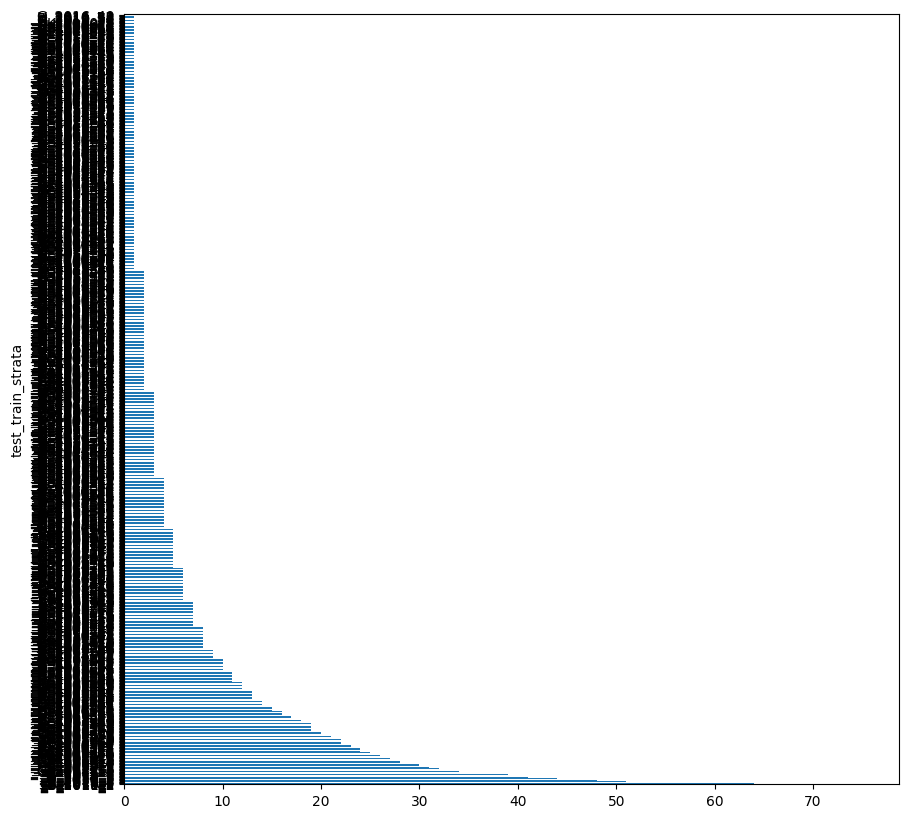

In [260]:
# Get temporary df
df_before_split = df_dropped_user_cols.copy()

# Attach test_train_strata dummy
df_before_split["test_train_strata"] = ""

# Attach test_train_strata variables
for var in test_train_strata:
    df_before_split["test_train_strata"] = df_before_split["test_train_strata"] + (
        "_" + df_before_split[var].astype(str)
    )

# Check how many stratification lvls there are
stratification_lvls = df_before_split["test_train_strata"].nunique()
print(
    f"Stratification levels: {stratification_lvls}, based on variables: {test_train_strata}."
)

# Plot distribution of stratification levels
df_before_split["test_train_strata"].value_counts().plot(kind="barh", figsize=(10, 10))


Shape before removing strata with less than 10 observations: (7427, 12)
Shape after removing strata with less than 10 observations: (4389, 12)


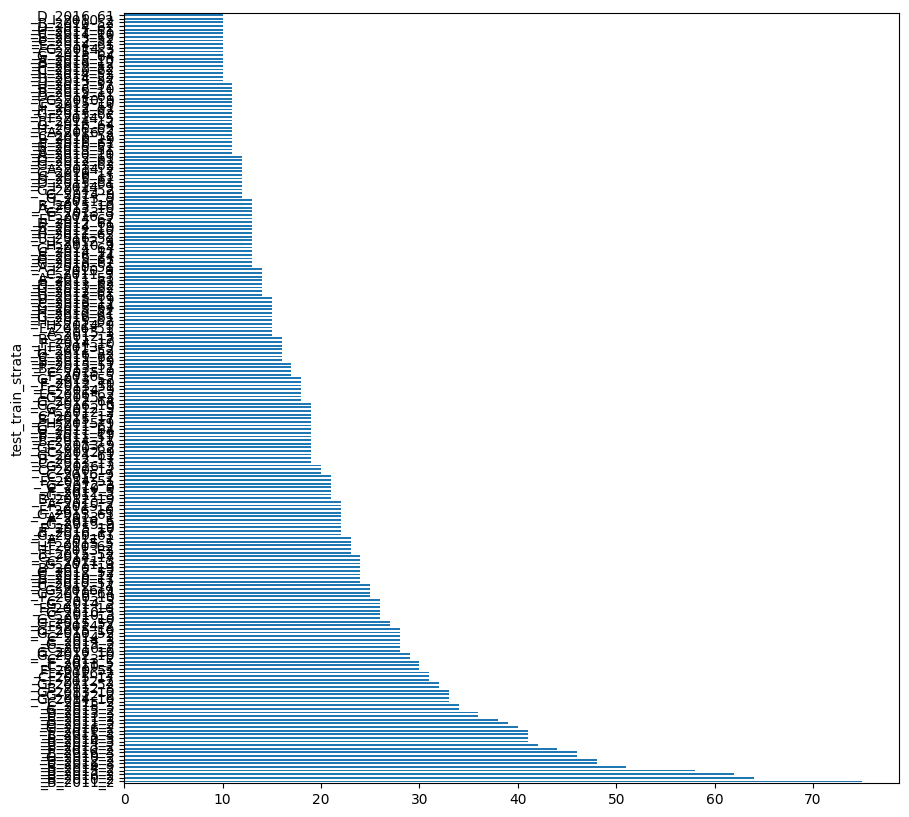

In [261]:
df_tmp = df_before_split.copy()

# Remove rows where stratification level belongs to a group that has less than x observations
strat_cutoff = 10
stratification_counts = df_before_split["test_train_strata"].value_counts()
stratification_counts = stratification_counts[stratification_counts < strat_cutoff]
stratification_counts = stratification_counts.index.to_list()

df_tmp = df_tmp.query("test_train_strata not in @stratification_counts")

print(
    f"\nShape before removing strata with less than {strat_cutoff} observations: {df_before_split.shape}"
    f"\nShape after removing strata with less than {strat_cutoff} observations: {df_tmp.shape}"
)
df_tmp["test_train_strata"].value_counts().plot(kind="barh", figsize=(10, 10))

df_dropped_stratif = df_tmp.copy()

In [293]:
df_tmp = df_dropped_stratif.copy()

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df_tmp.drop(target, axis=1),
    df_tmp[target],
    test_size=test_split,
    random_state=seed_nr,
    stratify=df_tmp["test_train_strata"],
)

# Remove stratification column
remove_these = [
    "test_train_strata"
]  # + test_train_strata # TODO Should the stratification variables be removed?
X_train = X_train.drop(remove_these, axis=1)
X_test = X_test.drop(remove_these, axis=1)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (3511, 10)
Shape of X_test: (878, 10)
Shape of y_train: (3511,)
Shape of y_test: (878,)


In [294]:
# Document data into txt files
buffer = StringIO()
X_train.info(buf=buffer, verbose=True)
info_str = buffer.getvalue()
file_path = f"{current_dir}/X_train_info_before_imputation.txt"
with open(file_path, "w") as file:
    file.write(info_str)

buffer = StringIO()
X_test.info(buf=buffer, verbose=True)
info_str = buffer.getvalue()
file_path = f"{current_dir}/X_test_info_before_imputation.txt"
with open(file_path, "w") as file:
    file.write(info_str)

## Preprocessing

In [295]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer

# Reduce vars_to_ohe to only hold variables that are in the dataset
vars_to_ohe_red = [var for var in vars_to_ohe if var in X_train.columns]

# Save to file what variables have been ohe
file_path = f"{current_dir}/ohe_variables.txt"
with open(file_path, "w") as file:
    for item in vars_to_ohe_red:
        file.write(f"{item}\n")

# One-hot encoding
ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
X_train_encoded = pd.DataFrame(
    ohe.fit_transform(X_train[vars_to_ohe_red]),
    columns=ohe.get_feature_names_out(vars_to_ohe_red),
)

X_test_encoded = pd.DataFrame(
    ohe.transform(X_test[vars_to_ohe_red]),
    columns=ohe.get_feature_names_out(vars_to_ohe_red),
)

# Concatenate the encoded variables with the rest of the dataset
# A bit hacky because the index is reset, but it works
df1 = X_train.drop(vars_to_ohe_red, axis=1).reset_index(drop=True)
df2 = X_train_encoded.reset_index(drop=True)
X_train = pd.concat([df1, df2], axis=1)

df1 = X_test.drop(vars_to_ohe_red, axis=1).reset_index(drop=True)
df2 = X_test_encoded.reset_index(drop=True)
X_test = pd.concat([df1, df2], axis=1)

# KNN imputation
if len(numerics_with_na) > 0:
    imputer = KNNImputer(n_neighbors=5)
    X_train[numerics_with_na] = imputer.fit_transform(X_train[numerics_with_na])
    X_test[numerics_with_na] = imputer.transform(X_test[numerics_with_na])

# Shape of train and text set
print(f"Shape of X_train after pre-processing: {X_train.shape}")
print(f"Shape of X_test after pre-processing: {X_test.shape}")

# Write dataframe infos to text
buffer = StringIO()
X_train.info(buf=buffer, verbose=True)
info_str = buffer.getvalue()
file_path = f"{current_dir}/X_train_info_after_imputation.txt"
with open(file_path, "w") as file:
    file.write(info_str)

buffer = StringIO()
X_test.info(buf=buffer, verbose=True)
info_str = buffer.getvalue()
file_path = f"{current_dir}/X_test_info_after_imputation.txt"
with open(file_path, "w") as file:
    file.write(info_str)

nincid_2
gre
top1_species
top2_species
top3_species
Shape of X_train after pre-processing: (3511, 136)
Shape of X_test after pre-processing: (878, 136)


## Fit Model

### Random Grid Search

In [281]:
run_cell = False

if run_cell:
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import RandomizedSearchCV

    # Number of trees in random forest
    # n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
    n_estimators = [int(x) for x in np.linspace(start=10, stop=2500, num=5)]

    # Number of features to consider at every split
    max_features = ["auto", "sqrt"]

    # Maximum number of levels in tree
    # max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
    max_depth = [int(x) for x in np.linspace(1, 25, num=5)]
    max_depth.append(None)

    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]

    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]

    # Method of selecting samples for training each tree
    bootstrap = [True, False]

    # Create the random grid
    random_grid = {
        "n_estimators": n_estimators,
        "max_features": max_features,
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf,
        # "bootstrap": bootstrap,
    }

    for key, value in random_grid.items():
        print(f"{key}: {value}")

    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestRegressor()

    # Random search of parameters, using 3 fold cross validation,
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(
        estimator=rf,
        param_distributions=random_grid,
        n_iter=100,
        cv=5,
        verbose=1,
        random_state=seed_nr,
        n_jobs=-1,
        return_train_score=True,
    )

    # Fit the random search model
    rf_random.fit(X_train, y_train)

    # Print results
    print(
        rf_random.best_estimator_
    )  # Output: RandomForestRegressor(max_features='sqrt', n_estimators=1255)
    print(rf_random.best_score_)  # Output: 0.18764794450728156
    print(rf_random.best_params_)

### Prescribed Grid Search

In [267]:
run_cell = False

if run_cell:
    # Define the parameter grid
    param_grid = {
        "n_estimators": [
            10,
            50,
            100,
            500,
            1000,
            2500,
        ],  # , 1000, 2000, 5000],  # 500, 1000, 2500],
        "max_features": ["sqrt", "log2"],  # ["auto", "sqrt", "log2"],
        "max_depth": [5, 6, 8, 15, 30],  # 10],  # , 50, 100],
        # 'criterion' :['gini', 'entropy']
    }

    # Create a base model
    rf = RandomForestRegressor()

    # Instantiate the grid search model
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,
        verbose=1,
        return_train_score=True,
    )

    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)

    plot_grid_search_results(grid_search)

### Fit best model

In [282]:
# best_params = grid_search.best_params_ # Get the best parameters

# best parameters based on random search:
best_params = {
    "n_estimators": 1255,
    "min_samples_split": 2,
    "min_samples_leaf": 1,
    "max_features": "sqrt",
    "max_depth": None,
}

# Write to file
file_path = f"{current_dir}/parameters_of_final_rf.txt"
with open(file_path, "w") as file:
    for key, value in best_params.items():
        file.write(f"{key}:\n - {value}\n\n")

# Fit the model to the training data
rf_best = RandomForestRegressor(
    **best_params, random_state=seed_nr, n_jobs=-1
)  # Create best model
rf_best.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', n_estimators=1255, n_jobs=-1,
                      random_state=42)

### REFCV

In [283]:
run_cell = False
if run_cell:
    from sklearn.feature_selection import RFECV
    from sklearn.model_selection import StratifiedKFold

    min_features_to_select = 1  # Minimum number of features to keep
    step = 0.1  # Integer number or percentage of features to remove at each iteration

    rf = RandomForestRegressor(
        n_estimators=10,
        random_state=seed_nr,
    )
    # cv = StratifiedKFold(5)
    # cv = Cross

    rfecv = RFECV(
        estimator=rf,
        step=step,
        cv=3,
        scoring="r2",
        min_features_to_select=min_features_to_select,
        n_jobs=-1,
    )

    rfecv.fit(X_train, y_train)

    print(f"Optimal number of features: {rfecv.n_features_}")

    n_scores = len(rfecv.cv_results_["mean_test_score"])
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Mean test accuracy")
    plt.errorbar(
        range(min_features_to_select, n_scores + min_features_to_select),
        rfecv.cv_results_["mean_test_score"],
        yerr=rfecv.cv_results_["std_test_score"],
    )
    plt.title("Recursive Feature Elimination \nwith correlated features")
    plt.show()

## Evaluate Model

### Variable Importance

Original size of df_featimp:  (136, 2)


,Feature,Importance
0,dom_nr1_tree_class_ba_abs,0.129506
1,ntrees_1,0.110775
2,ntrees_2,0.101484
3,site_ba_prc_dead_at_v1,0.066800
4,campagne_1,0.058564
5,nincid_2_0,0.039193
6,nincid_2_2,0.025914
7,top1_species_19,0.016401
8,nincid_2_4,0.016314
9,top3_species_none,0.014899


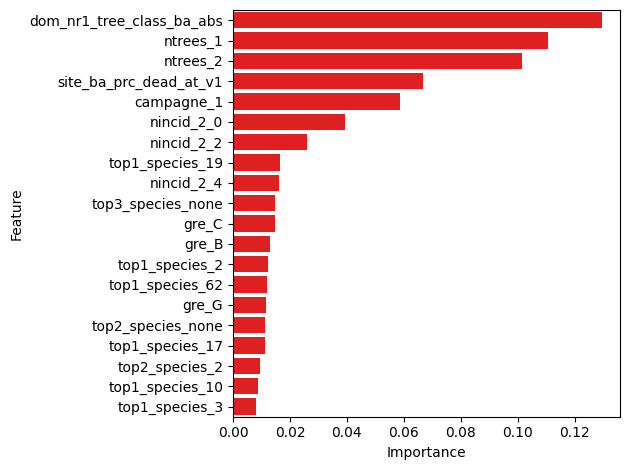

In [284]:
show_top_predictors(X_train, vars_to_ohe_red, rf_best, with_aggregation=False)

Original size of df_featimp:  (136, 2)


'Aggregating variables...'

Merged 6 vars into nincid_2 containing: ['nincid_2_0', 'nincid_2_2', 'nincid_2_4', 'nincid_2_5', 'nincid_2_1', 'nincid_2_3']
Merged 10 vars into gre containing: ['gre_C', 'gre_B', 'gre_G', 'gre_F', 'gre_A', 'gre_H', 'gre_D', 'gre_E', 'gre_I', 'gre_J']
Merged 16 vars into top1_species containing: ['top1_species_19', 'top1_species_2', 'top1_species_62', 'top1_species_17', 'top1_species_10', 'top1_species_3', 'top1_species_52', 'top1_species_9', 'top1_species_61', 'top1_species_51', 'top1_species_24', 'top1_species_5', 'top1_species_64', 'top1_species_11', 'top1_species_12', 'top1_species_57']
Merged 48 vars into top2_species containing: ['top2_species_none', 'top2_species_2', 'top2_species_11', 'top2_species_12', 'top2_species_3', 'top2_species_25', 'top2_species_17', 'top2_species_9', 'top2_species_49', 'top2_species_51', 'top2_species_10', 'top2_species_21', 'top2_species_15', 'top2_species_61', 'top2_species_31', 'top2_species_52', 'top2_species_20', 'top2_species_62', 'top2_species_2

'df_featimp after merging: '

(10, 2)

,Feature,Importance
8,top2_species,0.150291
0,dom_nr1_tree_class_ba_abs,0.129506
9,top3_species,0.126643
1,ntrees_1,0.110775
2,ntrees_2,0.101484
7,top1_species,0.099969
5,nincid_2,0.088919
6,gre,0.067048
3,site_ba_prc_dead_at_v1,0.066800
4,campagne_1,0.058564


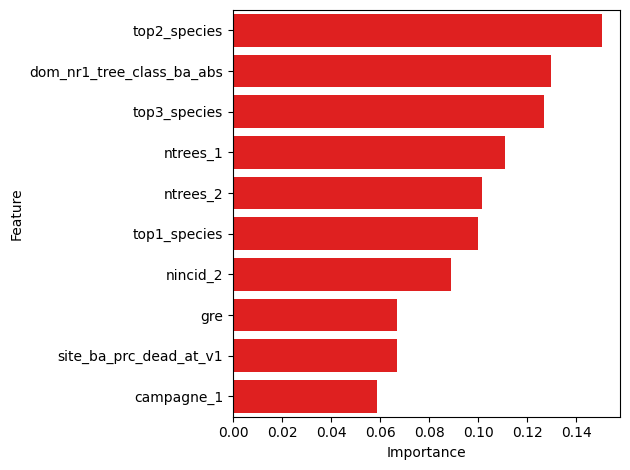

In [285]:
show_top_predictors(X_train, vars_to_ohe_red, rf_best, with_aggregation=True)

### Mod-Obs

R2 score:  0.2243105605706125
RMSE:  2.1426686433734026
MAE:  1.3559991595202918


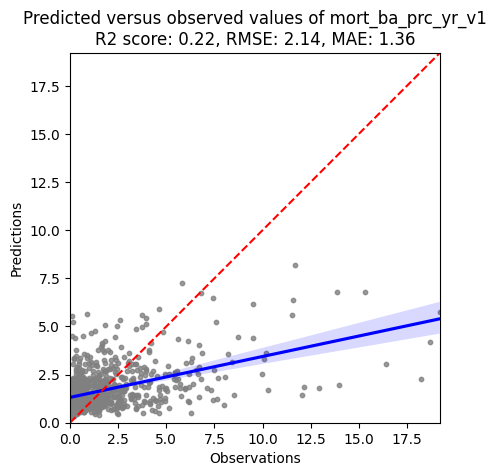

In [286]:
model_evaluation(rf_best, X_test, y_test)

## Save Model

In [288]:
import pickle

# Pickle model
with open(f"{current_dir}/final_model.pkl", "wb") as f:
    pickle.dump(rf_best, f)

# Pickle test data
with open(f"{current_dir}/X_test.pkl", "wb") as f:
    pickle.dump(X_test, f)

with open(f"{current_dir}/y_test.pkl", "wb") as f:
    pickle.dump(y_test, f)

---

In [274]:
# from sklearn.feature_selection import RFECV
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.datasets import make_regression

# # Example dataset
# X, y = make_regression(
#     n_samples=100, n_features=10, n_informative=2, random_state=0, shuffle=False
# )

# # Split data
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# # RandomForestRegressor model
# regr = RandomForestRegressor(n_estimators=100, random_state=0)

# # RFECV with neg_mean_squared_error scorer
# rfecv = RFECV(estimator=regr, step=1, cv=5, scoring="neg_mean_absolute_error")
# rfecv = rfecv.fit(X_train, y_train)

# print("Optimal number of features : %d" % rfecv.n_features_)

# n_scores = len(rfecv.cv_results_["mean_test_score"])
# plt.figure()
# plt.xlabel("Number of features selected")
# plt.ylabel("Mean test accuracy")
# plt.errorbar(
#     range(min_features_to_select, n_scores + min_features_to_select),
#     rfecv.cv_results_["mean_test_score"],
#     yerr=rfecv.cv_results_["std_test_score"],
# )
# plt.title("Recursive Feature Elimination \nwith correlated features")
# plt.show()

In [275]:
# from sklearn.feature_selection import RFECV
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.datasets import make_regression

# # Example dataset
# X, y = make_regression(
#     n_samples=100, n_features=10, n_informative=2, random_state=0, shuffle=False
# )

# # Split data
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# # RandomForestRegressor model
# regr = RandomForestRegressor(n_estimators=100, random_state=0)

# # RFECV with neg_mean_squared_error scorer
# rfecv = RFECV(estimator=regr, step=1, cv=5, scoring="r2")
# rfecv = rfecv.fit(X_train, y_train)

# print("Optimal number of features : %d" % rfecv.n_features_)

# n_scores = len(rfecv.cv_results_["mean_test_score"])
# plt.figure()
# plt.xlabel("Number of features selected")
# plt.ylabel("Mean test accuracy")
# plt.errorbar(
#     range(min_features_to_select, n_scores + min_features_to_select),
#     rfecv.cv_results_["mean_test_score"],
#     yerr=rfecv.cv_results_["std_test_score"],
# )
# plt.title("Recursive Feature Elimination \nwith correlated features")
# plt.show()

In [276]:
# for x in tree_vars["var"]:
#     print(x)
# # df_tmp["instp5"].replace("0.0", "0")

# "acci" in tree_vars["var"].to_list()